This notebook will reimplement the autoencoder model from notebook 04, but will do so using Pytorch instead of Tensorflow. 

Everything else in the notebook will remain the same, and some hints are given at the end on how to implement a sample/batch-specific dataloader (each minibatch only has samples from one single-cell sample/batch)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1"

import numpy as np
import pandas as pd
import scanpy as sc 
import anndata as ann
import episcanpy as esc

In [2]:
os.chdir("..")
multiome = sc.read_h5ad("data/multimodal/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [3]:
gex = multiome[:, multiome.var["feature_types"] == "GEX"] # Subset all data, not just the counts 
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection

atac = multiome[:, multiome.var["feature_types"] == "ATAC"] # Subset all data, not just the counts 
esc.pp.select_var_feature(atac, nb_features=5000, show=False) # Feature-selection - most variable features

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `.var` of view, copying.


Now we can go ahead and load the pytorch libraries and create the autoencoder. This autoencoder will have some more bells and whistles, as a lot more stuff is done manually in pytorch  

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
hvg_indices = gex.var["highly_variable"]
gex_arr = gex.X.todense()[:, hvg_indices]
gex_tensor = torch.from_numpy(gex_arr)

In [6]:
atac_arr = atac.X.todense()
atac_tensor = torch.from_numpy(atac_arr)

In [7]:
gex_atac_concat = torch.cat([gex_tensor, atac_tensor], axis = 1)
gex_atac_concat.shape

torch.Size([69249, 7501])

In [12]:
latent_dim = 20 # Specify the size of our latent dimension 
gex_dim = 2500
atac_dim = 5001

# We're going to define this function to initialize weights 
# To learn more about xavier initialization, see:
# https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

# Create the model class for our AutoEncoder - this follows mostly for the tutorial from 
# https://www.tensorflow.org/tutorials/generative/autoencoder, except we're putting a multi-modal
# flavor on it and ensuring it uses and reconstructs both GEX and ATAC outputs 
class MultiModalAutoencoder(nn.Module):
    def __init__(self, latent_dim, gex_dim, atac_dim):
        super(MultiModalAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.gex_dim = gex_dim
        self.atac_dim = atac_dim
        # We have two encoders and decoder - for each modality
        # We divide latent dim by two because we are going to 
        # concatenate the two modalities in latent space and
        # then use that concatenated representation to reconstruct
        # each modality 
        self.gex_encoder = nn.Sequential(
            nn.Linear(self.gex_dim, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Linear(250, int(self.latent_dim/2)),
            nn.BatchNorm1d(int(self.latent_dim/2)),
            nn.ReLU()
        )
        self.atac_encoder = nn.Sequential(
            nn.Linear(self.atac_dim, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Linear(250, int(self.latent_dim/2)),
            nn.BatchNorm1d(int(self.latent_dim/2)),
            nn.ReLU()
        )
        self.gex_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Linear(250, self.gex_dim),
            nn.ReLU()
        )
        self.atac_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Linear(250, self.atac_dim),
            nn.Sigmoid()
        )
        
        # Weight initialization 
        self.gex_encoder.apply(weights_init)
        self.atac_encoder.apply(weights_init)
        self.gex_decoder.apply(weights_init)
        self.atac_decoder.apply(weights_init)
        
    def gex_encode(self, gex_X):
        gex_Z = self.gex_encoder(gex_X)
        return gex_Z
    
    def gex_decode(self, gex_atac_c):
        gex_X_decoded = self.gex_decoder(gex_atac_c)
        return gex_X_decoded
        
    def atac_encode(self, atac_X):
        atac_Z = self.atac_encoder(atac_X)
        return atac_Z
        
    def atac_decode(self, gex_atac_c):
        atac_X_decoded = self.atac_decoder(gex_atac_c)
        return atac_X_decoded
        
    def forward(self, gex_atac_X):
        # Extract the data
        gex_X = gex_atac_X[:, 0:2500]
        atac_X = gex_atac_X[:, 2500:]
        # Encode both the GEX and ATAC data 
        gex_Z = self.gex_encode(gex_X)
        atac_Z = self.atac_encode(atac_X)
        # Concatenate the two encoded modalities 
        gex_atac_c = torch.cat([gex_Z, atac_Z], axis =1) # This is our latent we'll use later
        # Use the concatenated representation to recover both GEx and ATAC
        gex_X_decoded = self.gex_decode(gex_atac_c)
        atac_X_decoded = self.atac_decode(gex_atac_c)
        gex_atac_X_decoded = torch.cat([gex_X_decoded, atac_X_decoded], axis=1)
        return gex_atac_X_decoded 
    
# We're going to define a custom loss as we need a separate loss for both modalities 
# For GEX, since the data is continuous, we can use a mean-squared error loss 
# For ATAC, since the data is binary, we'll use a binarycrossentropy loss 
# We'll combine these to have even weight for now - but the scaling can be played around with
# (And maybe even treated as a hyperparameter)
def multimodal_loss(gex_atac_true, gex_atac_pred):
    # GEX loss 
    mse = nn.MSELoss()
    gex_true = gex_atac_true[:, 0:2500]
    gex_pred = gex_atac_pred[:, 0:2500]
    gex_loss = mse(gex_pred, gex_true)
    
    # ATAC loss 
    bce = nn.BCELoss()
    atac_true = gex_atac_true[:, 2500:]
    atac_pred = gex_atac_pred[:, 2500:]
    atac_loss = bce(atac_pred, atac_true)
    
    # Combine both and return
    loss = gex_loss*10 + atac_loss*1
    return loss 

Initialize the model, optimizer, and let's train this thing

In [17]:
# Initialize autoencoder
autoencoder = MultiModalAutoencoder(
    latent_dim = latent_dim,
    gex_dim = gex_dim,
    atac_dim = atac_dim
)

# Create dataloader for concatenated data
gex_atac_loader = DataLoader(
    dataset = gex_atac_concat,
    batch_size = 512,
    shuffle = True,
    num_workers = 4,
    drop_last = True
)

# use the GPU if available (it should be)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
autoencoder.double().to(device)

# Adam optimizer 
optimizer = optim.Adam(
    autoencoder.parameters(),
    lr = 0.001,
    weight_decay = 0
)

# Train the model for 20 epochs 
autoencoder.train()
for epoch in range(10):
    running_recon_loss = 0.0
    steps = 0
    for index, batch in enumerate(gex_atac_loader):
        optimizer.zero_grad()
        inputs = batch.double().to(device)
        outs = autoencoder.forward(inputs)
        loss = multimodal_loss(inputs, outs)
        running_recon_loss += loss.cpu().detach().item()
        steps += 1
        loss.backward()
        optimizer.step()
    epoch_recon_loss = running_recon_loss/steps
    print(
        "Epoch " + 
        str(epoch) + 
        " recon loss: " +
        str(round(epoch_recon_loss, 10))
    )

Epoch 0 recon loss: 1538.804903302
Epoch 1 recon loss: 1254.9950535079
Epoch 2 recon loss: 1004.2922929334
Epoch 3 recon loss: 748.2587913071
Epoch 4 recon loss: 544.3645126141
Epoch 5 recon loss: 410.4169699843
Epoch 6 recon loss: 306.7031326196
Epoch 7 recon loss: 261.6292165435
Epoch 8 recon loss: 222.7941391007
Epoch 9 recon loss: 207.8144930026


Now let's get the embeddings and evaluate as we usually do 

In [21]:
# Create a dataloader with a batch size of 1 and no shuffle 
gex_atac_oneloader = DataLoader(
    dataset = gex_atac_concat,
    batch_size = 1,
    shuffle = False,
    num_workers = 4,
    drop_last = False
)

# Put the model in eval mode and turn off torch gradients to get 
# the model embeddings 
autoencoder.eval()
with torch.no_grad():
    # Have to move tensors to device and put them in the same dtype or else
    # this won't work
    gex_Z = autoencoder.gex_encoder(gex_tensor.double().to(device))
    atac_Z = autoencoder.atac_encoder(atac_tensor.double().to(device))
    
Z_concat = torch.cat([gex_Z, atac_Z], axis=1)
Z_concat_np = Z_concat.cpu().detach().numpy()

In [23]:
from helpers.eval_embeddings import EvalEmbeddings

In [25]:
eval_obj = EvalEmbeddings(adata=gex) # Initialize the class
eval_obj.evaluate(Z_concat_np) # Evaluate

2022-12-07 17:01:19.567212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(0.5596528743933998,
    celltype_ari  celltype_ami  celltype_homogeneity  celltype_complete  \
 0      0.172654      0.430139              0.483463           0.388877   
 
    batch_ari  batch_ami  batch_homogeneity  batch_complete  
 0   0.938438   0.818307           0.786217        0.840868  )

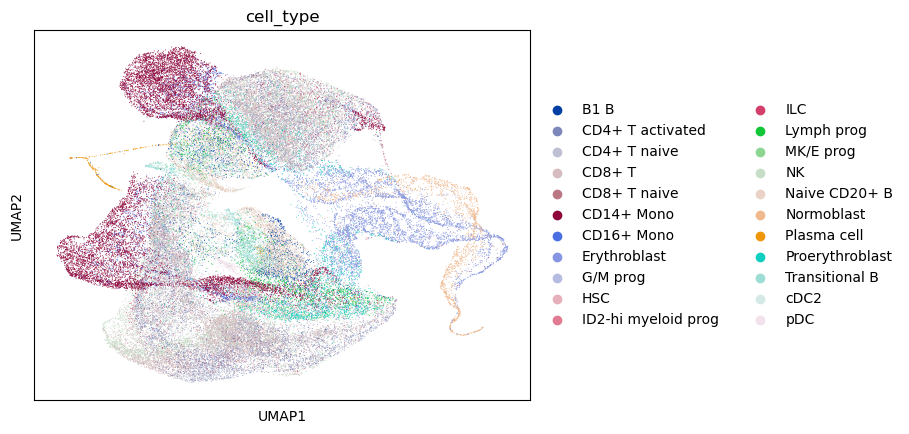

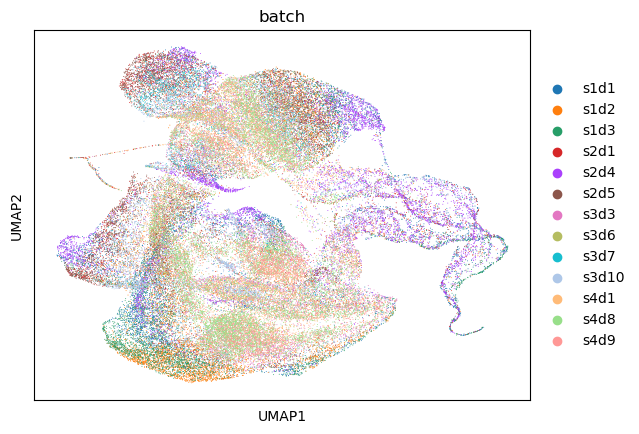

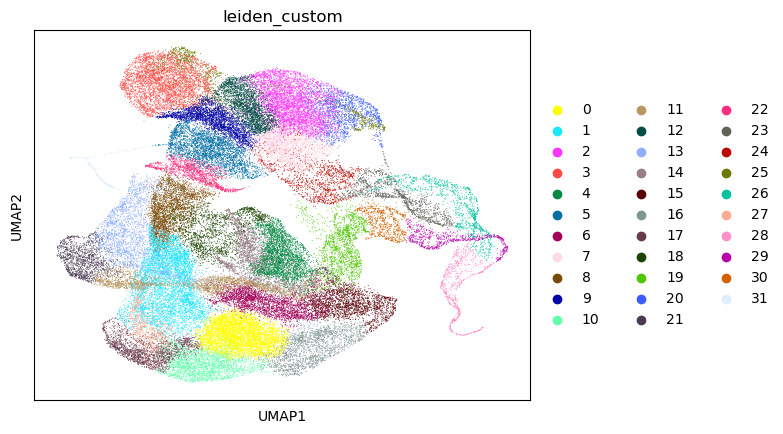

In [26]:
eval_obj.plot() # Plot the results 